# Telegram Group Chat analysis

I've often felt I was the most talkative among my closest friends. Since I'm a scientist, I decided to put this to the test using a few Data Science techniques. The results I found were pretty Interesting

In [1]:
# taking care of dependencies I'll be using
import json
import pandas as pd
import unidecode
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import plotly.express as px
from datetime import datetime
import numpy as np
import matplotlib
import re
import seaborn as sns
from itertools import groupby
from nltk.util import ngrams
import collections
from collections import defaultdict
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

###### Telegram allows you to download your personal chat history in json format. I won't be sharing mine for obvious reasons, but this notebook should be easily applicable to your personal / group chat data.

In [2]:
#loading up the result.json data file just as it was provided by Telegram
data_file= 'data/terapia_de_grupo/result.json'

with open(data_file) as json_file:
    data = json.load(json_file)

## Let's do some exploratory analysis for this data...

In [3]:
data.keys()

dict_keys(['name', 'type', 'id', 'messages'])

In [4]:
data['type']

'private_group'

In [5]:
data['name']

'Terapia de grupo'

In [6]:
# now, let's see how many messages we've got, then...
len(data['messages'])

22732

###### For obvious reasons I've obfuscated `from` and `from_id`

In [7]:
# then let's see what a message looks like
data['messages'][:3]

[{'id': 9369,
  'type': 'service',
  'date': '2018-02-24T10:44:08',
  'actor': 'Alice',
  'actor_id': 1,
  'action': 'create_group',
  'title': 'Terapia de grupo',
  'members': ['Alice', 'Bob', 'Trudy'],
  'text': ''},
 {'id': 9370,
  'type': 'message',
  'date': '2018-02-24T10:44:15',
  'from': 'Alice',
  'from_id': 1,
  'file': 'stickers/sticker.webp',
  'thumbnail': 'stickers/sticker.webp_thumb.jpg',
  'media_type': 'sticker',
  'sticker_emoji': '💝',
  'width': 512,
  'height': 512,
  'text': ''},
 {'id': 9371,
  'type': 'message',
  'date': '2018-02-24T10:44:25',
  'from': 'Trudy',
  'from_id': 3,
  'text': 'Jajajaja'}]

#### At a glance this seems to be a pretty simple structure:

* Some messages might have an `action`, like that first element that identifies the `create_group` action
* Messages have an `actor` and it's associated `actor_id`
* There's an `id` that's correlative to my personal messages (yeah, I've checked: I've got 9000 accumulated messages previous to the creation of this group)
* We are interested in the messages that have `type` equal to `message`, and within those we are interested in the `text` field
* We might also consider those which have `media_type` since they might provide insight on the kind of emotes my friends use
* There might be some other message types, like `thumbnail` and `link`, so we'll need some further exploration

#### Moving on...

In [8]:
# loading `messages` to a DataFrame
df= pd.DataFrame(data['messages'])
df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
19590,35509,message,2020-06-27T12:37:44,NaN,NaN,NaN,NaN,NaN,pero el primer curso esta tan peola que el seg...,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9540,24944,message,2020-04-22T22:54:41,NaN,NaN,NaN,NaN,NaN,"tipo half life, counter y tf2",Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13974,29532,message,2020-05-25T18:35:14,NaN,NaN,NaN,NaN,NaN,siguiendo tu consejo arme una network con el p...,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4602,19902,message,2020-03-20T16:55:33,NaN,NaN,NaN,NaN,NaN,Lo van a devolver a cualquier lado jaja,Trudy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3946,19120,message,2020-03-17T00:45:00,NaN,NaN,NaN,NaN,NaN,es como.. PAW toma! trompada de informacion.. ...,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### But upon further analysis, we can see the message structure is not that trivial

In [9]:
df.keys()

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'members',
       'text', 'from', 'from_id', 'file', 'thumbnail', 'media_type',
       'sticker_emoji', 'width', 'height', 'mime_type', 'duration_seconds',
       'via_bot', 'photo', 'reply_to_message_id', 'forwarded_from',
       'message_id', 'edited'],
      dtype='object')

##### Apparently there are only two types of message
* `service`
* `message`

In [10]:
df['type'].unique()

array(['service', 'message'], dtype=object)

##### In case you are curious about those tagged `service` 

In [11]:
df.loc[df['type']=='service']

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
0,9369,service,2018-02-24T10:44:08,Alice,1.0,create_group,Terapia de grupo,"[Alice, Bob, Trudy]",,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,9425,service,2018-02-24T23:00:55,Bob,2.0,edit_group_photo,NaN,NaN,,NaN,...,640.0,640.0,NaN,NaN,NaN,photos/photo_3@24-02-2018_23-00-55.jpg,NaN,NaN,NaN,NaN
141,12248,service,2019-05-24T20:49:16,Bob,2.0,invite_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,15719,service,2020-02-21T09:16:57,Bob,2.0,pin_message,NaN,NaN,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15717.0,NaN
1300,15754,service,2020-02-21T09:37:53,Bob,2.0,remove_members,NaN,[bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307,15761,service,2020-02-21T10:19:56,Alice,1.0,invite_members,NaN,[Eve],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,17269,service,2020-03-03T23:27:49,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,17290,service,2020-03-03T23:30:05,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14741,30299,service,2020-05-29T00:54:00,Bob,2.0,invite_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14742,30300,service,2020-05-29T00:55:06,Bob,2.0,remove_members,NaN,[Book Download Bot],,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The only two actors who have run `service` actions were Alice and Bob

In [12]:
df.loc[df['type']=='service']['actor'].unique()

array(['Alice', 'Bob'], dtype=object)

#### For now I'm only interested in the proper messages (not the actions)... let's see if we can get some insights

In [13]:
msg_df= df.loc[df['type']=='message']
msg_df.sample(5)

,id,type,date,actor,actor_id,action,title,members,text,from,...,width,height,mime_type,duration_seconds,via_bot,photo,reply_to_message_id,forwarded_from,message_id,edited
2758,17552,message,2020-03-04T21:51:20,NaN,NaN,NaN,NaN,NaN,estaba mirando en glassdoor,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3481,18348,message,2020-03-12T20:11:56,NaN,NaN,NaN,NaN,NaN,sisi por eso abandoné el proyecto hace unas li...,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7372,22758,message,2020-04-04T15:25:26,NaN,NaN,NaN,NaN,NaN,es un epligro,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19904,35824,message,2020-06-28T20:45:20,NaN,NaN,NaN,NaN,NaN,entonces a veces el heat exchanger se esta ras...,Alice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3686,18833,message,2020-03-15T15:08:37,NaN,NaN,NaN,NaN,NaN,si!... tengo q instalarlo :-3,Bob,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Seems the DataFrame is pretty sparse... counting should make things easier. We've got over 22k `text` messages. That is A LOT! We'll have to come back to further explore this

In [14]:
message_count=msg_df.count()
message_count=message_count[message_count != 0] # filter out zero values
message_count['text']

22722

### For now, we'll be taking a closer look at the non-text-based message count

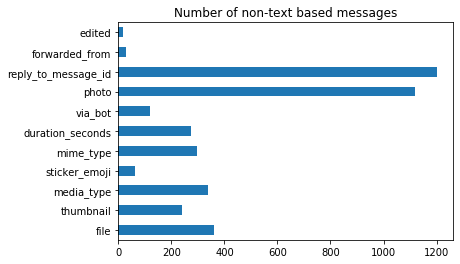

In [15]:
#dropping `text` messages and other columns that don't show interesting information
message_count_plot= message_count.drop(labels=['id','type','text','from','from_id','date','height','width'])
message_count_plot.plot.barh(title='Number of non-text based messages');

#### Some insights:
* We don't edit many of our messages after being sent
* We don't ussually forward messages
* We reply a lot of messages!
* We share a lot of images!
* We have a couple of bots
* The total amount of time in audio messages is relatively short
* We don't usually send a single emoji as a message
* We've shared over 300 files

##### Let's take a closer look at some of those insights...

In [16]:
reply_df= msg_df[['date','reply_to_message_id','from']].dropna()
reply_df

,date,reply_to_message_id,from
105,2019-05-05T16:17:09,11939.0,Alice
138,2019-05-20T17:03:29,12019.0,Alice
143,2019-05-24T20:49:20,12249.0,bot
148,2019-05-24T20:50:54,12254.0,bot
150,2019-05-24T23:09:11,12257.0,bot
...,...,...,...
22568,2020-07-10T19:28:00,38597.0,Bob
22601,2020-07-10T19:45:43,38660.0,Alice
22618,2020-07-10T19:48:21,38678.0,Alice
22682,2020-07-11T11:23:58,38732.0,Trudy


In [17]:
#some pandas-fu to create a df with the indexed dates for the replies
reply_df= pd.merge(reply_df.rename(columns={'reply_to_message_id': 'id'}),
        df[['reply_to_message_id','id','date']],
        on='id').rename(columns={'date_x': 'reply','date_y':'orig_msg'})[['reply','from','orig_msg']]
reply_df['delta']=pd.to_datetime(reply_df['reply']) - pd.to_datetime(reply_df['orig_msg']) #calculating the time delta
reply_df

,reply,from,orig_msg,delta
0,2019-05-05T16:17:09,Alice,2019-05-05T16:15:49,00:01:20
1,2019-05-20T17:03:29,Alice,2019-05-20T14:33:27,02:30:02
2,2019-05-24T20:49:20,bot,2019-05-24T20:49:20,00:00:00
3,2019-05-24T20:50:54,bot,2019-05-24T20:50:53,00:00:01
4,2019-05-24T23:09:11,bot,2019-05-24T23:09:10,00:00:01
...,...,...,...,...
1198,2020-07-10T19:28:00,Bob,2020-07-10T19:24:46,00:03:14
1199,2020-07-10T19:45:43,Alice,2020-07-10T19:45:33,00:00:10
1200,2020-07-10T19:48:21,Alice,2020-07-10T19:48:02,00:00:19
1201,2020-07-11T11:23:58,Trudy,2020-07-11T10:47:56,00:36:02


#### Now, let's plot each participant's delta time for replying.

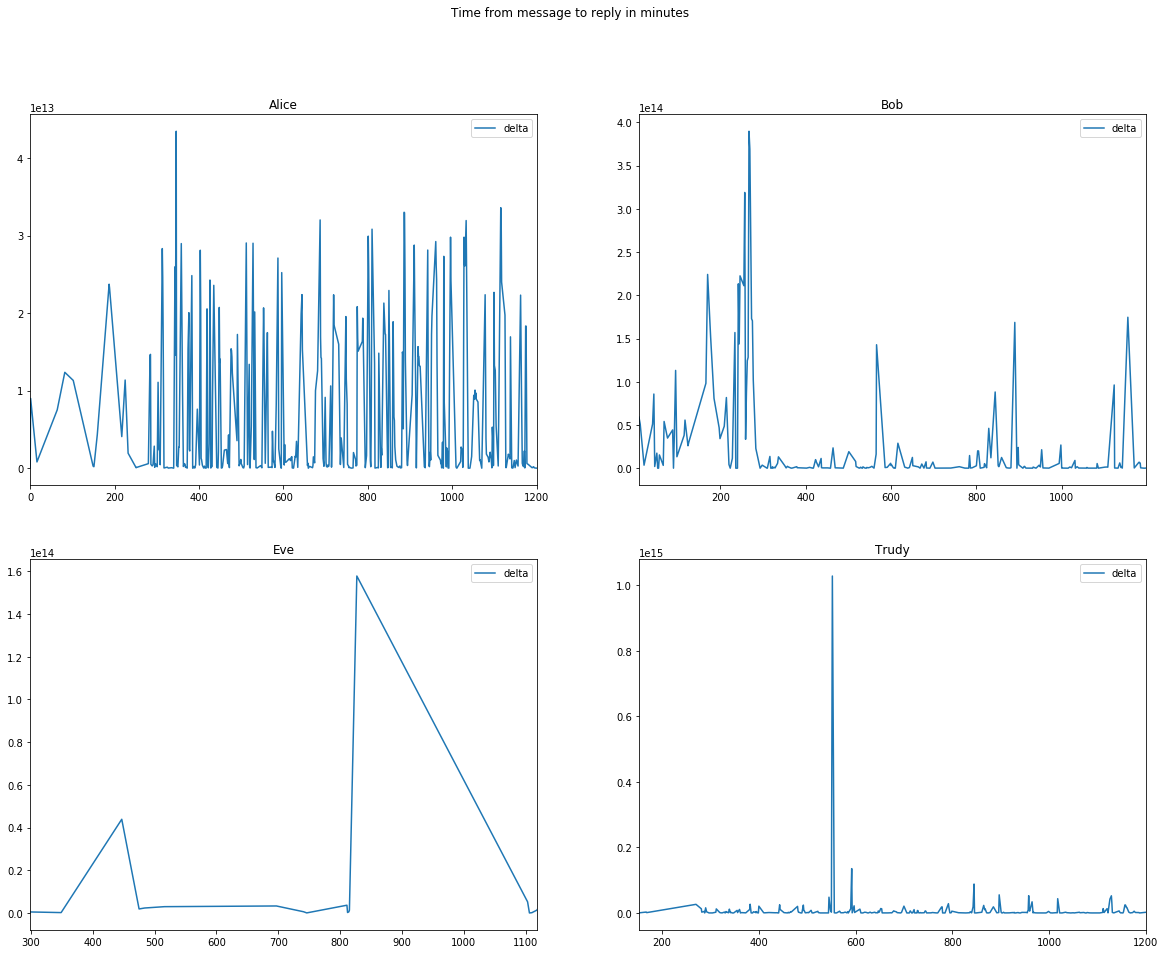

In [18]:
# might need this conversion
#reply_df['delta'] = pd.to_numeric(reply_df['delta'], errors='coerce')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
reply_df.loc[reply_df['from']=='Alice'].plot(ax=axes[0,0],
        y='delta',title='Alice'); axes[0,0].set_title('Alice')
reply_df.loc[reply_df['from']=='Bob'].plot(ax=axes[0,1],
        y='delta',title='Bob'); axes[0,1].set_title('Bob')
reply_df.loc[reply_df['from']=='Eve'].plot(ax=axes[1,0],
        y='delta',title='Eve'); axes[1,0].set_title('Eve')
reply_df.loc[reply_df['from']=='Trudy'].plot(ax=axes[1,1],
        y='delta',title='Trudy'); axes[1,1].set_title('Trudy')
fig.suptitle('Time from message to reply in minutes')
plt.show();

##### Apparently:
* `Alice` replies a lot, but takes several minutes to do so
* `Bob` has some seasonality, meaning every now and then he'll take his time
* `Trudy` doesn't take much time to reply, for the most part
* `Eve` doesn't reply much

###### I forgot about the bot, but I don't expect much, since it's supposed to respond immediately

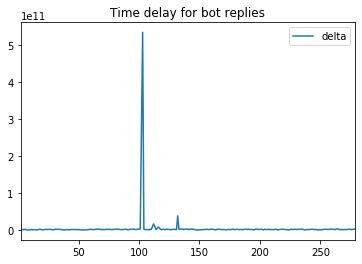

In [19]:
reply_df.loc[reply_df['from']=='bot'].plot(y='delta',title='Time delay for bot replies');

###### Woah! Another unexpected insight: at some point the bot had an issue and `delta` went up

## Let's move on to the next feature... Images!

##### Apparently, Telegram embeds the date on the file-name... kind of redundant if you ask me (?)

In [20]:
images_df= msg_df[['date','photo','from']].dropna()
images_df.sample(5)

,date,photo,from
7762,2020-04-07T09:15:20,photos/photo_398@07-04-2020_09-15-20.jpg,Bob
5871,2020-03-27T20:42:35,photos/photo_310@27-03-2020_20-42-35.jpg,Bob
16963,2020-06-10T20:25:23,photos/photo_841@10-06-2020_20-25-23.jpg,Bob
10732,2020-05-01T18:56:25,photos/photo_558@01-05-2020_18-56-25.jpg,Bob
17518,2020-06-14T20:38:57,photos/photo_876@14-06-2020_20-38-57.jpg,Bob


#### Counting the images sent by group member and...Well, well, well! It would seem like Bob is a pretty visual guy... 

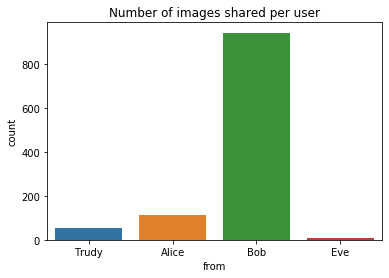

In [21]:
sns.countplot(x='from', data=images_df)
plt.title('Number of images shared per user');

#### Let's see the actual distribution of images sent by Bob over time

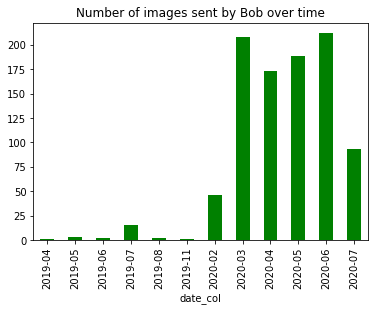

In [22]:
bobs_images_sent= images_df.loc[images_df['from']=='Bob']
bobs_images_sent['date_col'] = pd.to_datetime(bobs_images_sent['date'], utc=True)
bobs_images_sent.reset_index().set_index('date_col')
bobs_images_sent.set_index('date_col')
bobs_images_sent= bobs_images_sent['date_col'].groupby(
    bobs_images_sent.date_col.dt.to_period("M")).agg('count')
bobs_images_sent.plot.bar(color='g',title='Number of images sent by Bob over time');

###### looks like Bob alternates between months whith little to no activity and others when he sends over 175 pictures per month. There might be a tendency or some seasonality but we'll have to gather more data and come back to review this graph in the future

## What about files? We've shared over 350 files over the past two years, that sounds like a lot

In [23]:
file_df= df[['date','file','from']].dropna()
file_df

,date,file,from
1,2018-02-24T10:44:15,stickers/sticker.webp,Alice
4,2018-02-24T10:44:57,stickers/sticker (1).webp,Alice
6,2018-02-24T10:46:19,video_files/animation.gif.mp4,Alice
8,2018-02-24T10:47:14,video_files/giphy.mp4,Alice
15,2018-02-24T10:49:02,video_files/giphy (1).mp4,Trudy
...,...,...,...
22288,2020-07-10T09:18:22,stickers/sticker (46).webp,Alice
22315,2020-07-10T12:29:20,video_files/mp4 (28).mp4,Bob
22316,2020-07-10T12:31:15,video_files/animation (26).gif.mp4,Alice
22671,2020-07-11T10:48:13,video_files/mp4 (29).mp4,Bob


#### Oh... now I get it! At a glance, most of the files are gif and animations... that makes sense, right?
##### Let's explore this a bit further

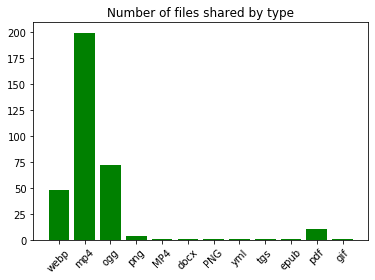

In [24]:
files_sent=file_df['file'].unique()
file_types=defaultdict(int)
for f in files_sent:
    file_types[f.split('.')[-1]]+=1

plt.bar(list(file_types.keys()),file_types.values(), color='g')
plt.title('Number of files shared by type')
plt.xticks(rotation=45)
plt.show();

##### That was unexpected... there are a lot of audio files `.ogg` that I was not considering.

#### Still... The majority of the files shared were animations and audio files, let's see who's been the most active sharing files

In [25]:
# create a column with the file extension so we can filter out who sends more of each type of files
tmp2_file_df=file_df[['file','from']]
tmp2_file_df= tmp2_file_df.file.str.split('.',expand=True)
tmp2_file_df['extension']=tmp2_file_df[2].fillna(tmp2_file_df[1])
ext_df= file_df[['date','from','file']].join(tmp2_file_df['extension'])
#ext_df

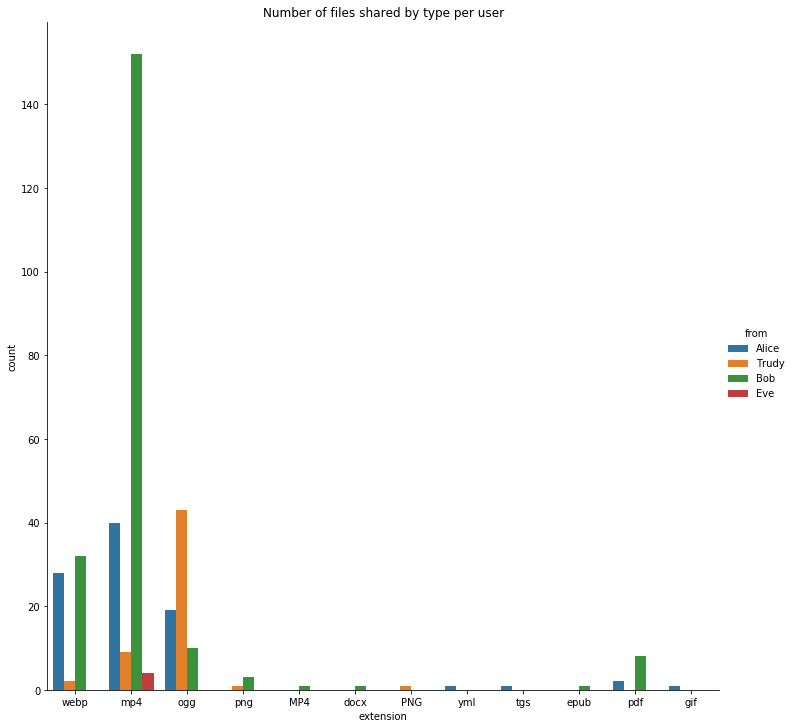

In [26]:
#plotting the distribution of files sent by each group member
g = sns.catplot(x="extension", hue="from",
                data=ext_df, kind="count",
                height=10)
plt.title('Number of files shared by type per user');

###### Once again, Bob proves he is the most visual member of the group by sending too many animations. One interesting find is that Trudy appears to be the most vocal member of the group, sending the most `.ogg` audio messages!

## Moving on to Emojis!

###### In Telegram, when you send a single emoji as a message or reply, it is displayed bigger and sometimes even animated. Let's analyze those solo-emoji messages. There's not much information to work with, but let's analyze it's distribution

In [27]:
solo_emoji_df= msg_df[['sticker_emoji','from']].dropna()
solo_emoji_df['sticker_emoji'].count()

62

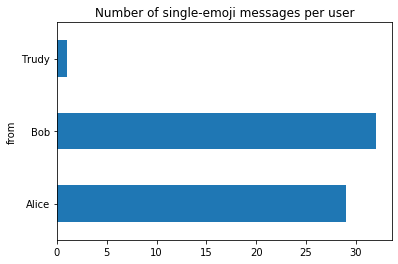

In [28]:
solo_emoji_df.groupby('from')['sticker_emoji'].count().plot.barh()
plt.title('Number of single-emoji messages per user');

In [29]:
# setting up a few pd.Series to count each member's single-emoji messages
solo_emoji_df=msg_df[['sticker_emoji','from']].dropna()
#alice
alice_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Alice']
alice_solo_emoji_count= alice_solo_emoji.groupby('sticker_emoji')['from'].count()
#bob
bob_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Bob']
bob_solo_emoji_count= bob_solo_emoji.groupby('sticker_emoji')['from'].count()
#trudy
trudy_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Trudy']
trudy_solo_emoji_count= trudy_solo_emoji.groupby('sticker_emoji')['from'].count()
#eve
eve_solo_emoji= solo_emoji_df.loc[solo_emoji_df['from']=='Eve']
eve_solo_emoji_count= eve_solo_emoji.groupby('sticker_emoji')['from'].count()

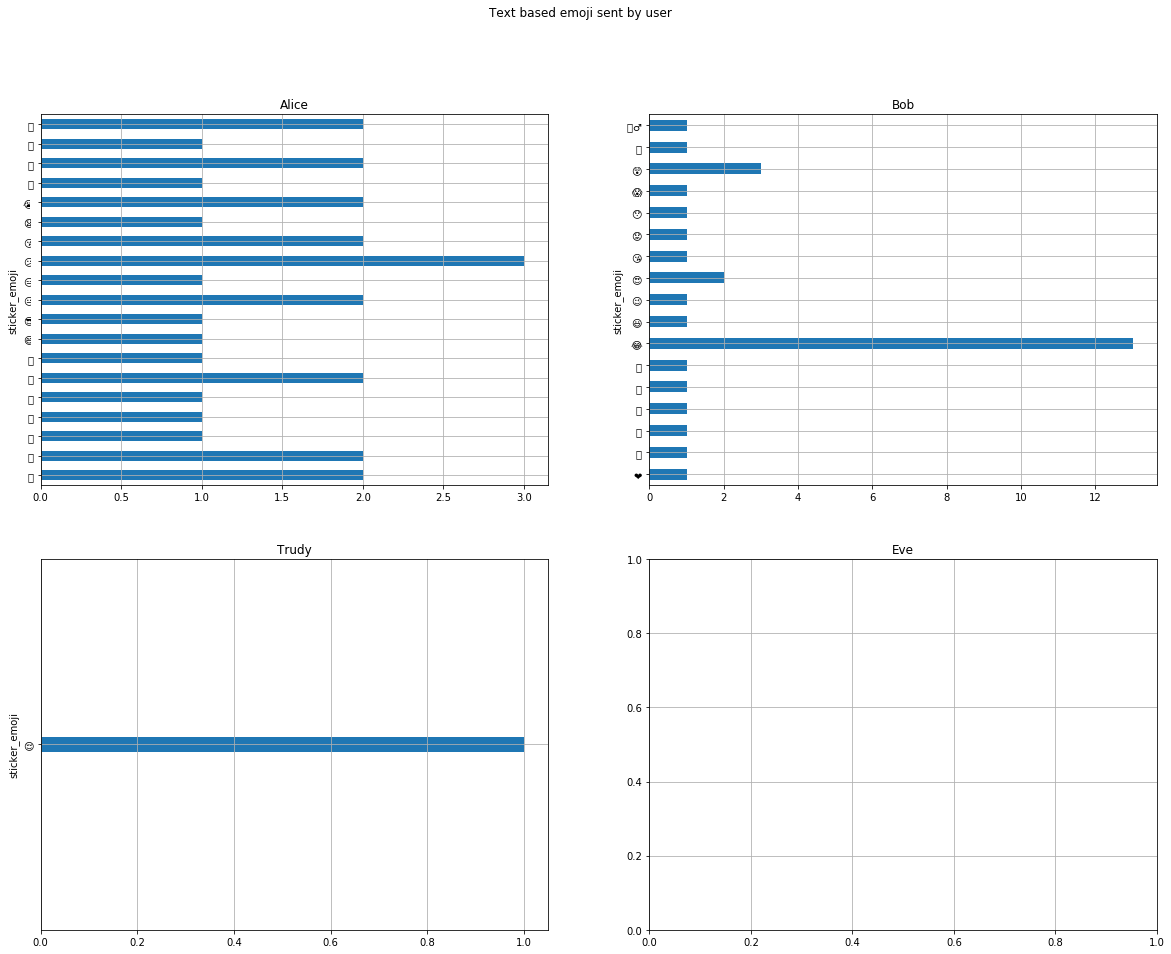

In [30]:
# plot 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
alice_solo_emoji_count.plot.barh(ax=axes[0,0],
        y='delta',title='Alice'); axes[0,0].set_title('Alice')
bob_solo_emoji_count.plot.barh(ax=axes[0,1],
        y='delta',title='Bob'); axes[0,1].set_title('Bob')
trudy_solo_emoji_count.plot.barh(ax=axes[1,0],
        y='delta',title='Trudy',width=0.02); axes[1,0].set_title('Trudy')
#eve_solo_emoji_count.plot.barh(ax=axes[1,1],
#        y='delta',title='Eve');
# Eve didn't send any single-emoji messages
axes[1,1].set_title('Eve')
axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
fig.suptitle('Text based emoji sent by user');
plt.show();

#### Well... once again, Bob is leading the charts with the amount of messages containing a single 😂 he sends. However, we've discovered that Alice appears to have a broader lexicon when it comes to emojis!

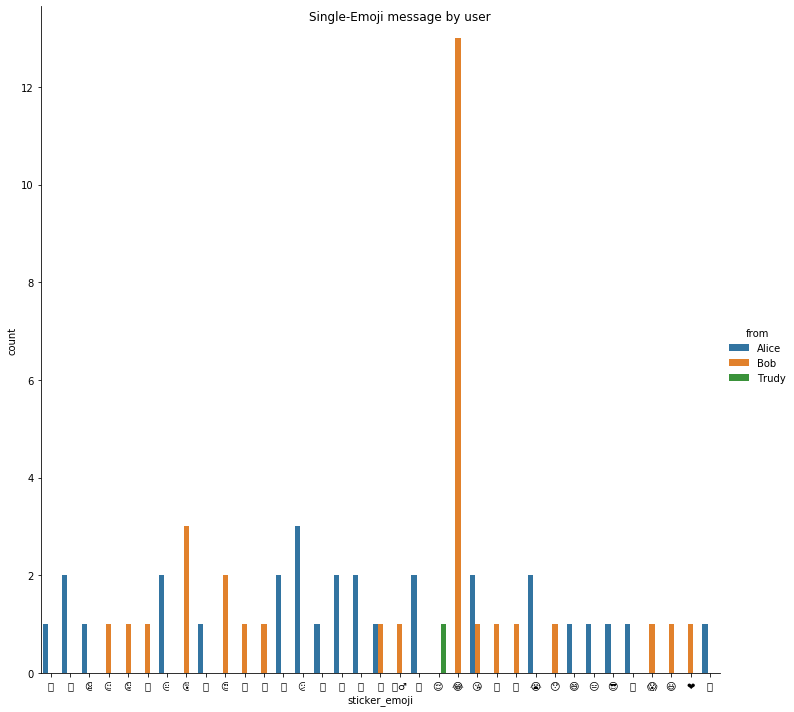

In [31]:
# plotting them all side by side for comparison
g = sns.catplot(x="sticker_emoji", hue="from",
                data=solo_emoji_df, kind="count",
                height=10,orient='h')
g.fig.suptitle('Single-Emoji message by user');

#### Either Bob is a jolly fellow or the other group members are very funny 😂

###### To further research this subject, we're going to have to dive deep into the `text` based messages and analyze the emojis within

## Let's look into those 22k text messages

In [32]:
# we're gonna be working with a text dataframe
text_df= msg_df[['date','from','text']]
text_df['text'].replace('', np.nan, inplace=True) # replace empty strings with NaN
text_df.dropna(subset=['text'], inplace=True) #drop NaN
text_df.sample(5)

,date,from,text
4758,2020-03-21T13:42:08,Bob,jjajaja
15710,2020-06-03T10:04:04,Bob,esta re manija :-p
4952,2020-03-22T10:15:41,Bob,"[este es genial... , {'type': 'link', 'text': ..."
9145,2020-04-19T14:43:46,Bob,"that's good... si vas a hacer asi, entonces me..."
13659,2020-05-24T18:06:36,Trudy,"Claro, pero no sabría cómo encarar el hecho de..."


#### Some data cleaning...

In [33]:
# a customized subset from nltk.stopwords('spanish')
sp_stopwords=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las',
              'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como',
              'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta',
              'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta',
              'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos',
              'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos',
              'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras',
              'otra', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 
              'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo',
              'nosotros', 'mi', 'mis', 'tú', 'te', 'tu', 'tus', 'ellas', 'mío',
              'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo',
              'suya', 'suyos', 'suyas', 'esos', 'esas', 'este', 'hay', 'soy', 'es',
              'de','to','the','is','here','a','of','it','we','for','that','this',
              'all','as','are']
stopwords=[unidecode.unidecode(word) for word in sp_stopwords] #normalizing stopwords

In [34]:
# a customized subset from wikipedia
emoj=[":‑)",":)",":-]",":]",":-3",":3",":->",":>","8-)","8)",
      ":-}",":}",":o)",":c)",":^)","=]","=)","= )","=^)",":‑D",
      ":D","8‑D","8D","x‑D","xD","X‑D","XD","=D","=3","B^D",
      ":^D","=^D",":‑(",":(",":‑c",":c",":‑<",":<",":‑[",":[",
      ":-||",">:[",":{",":@",":(",";(",":'‑(",":'(",":'‑)",
      ":')","D‑':","D:<","D:","D8","D;","D=","DX",":‑O",":O",
      ":‑o",":o",":-0","8‑0",">:O",":-*",":*",":×",";‑)",";)",
      "*-)","*)",";‑]",";]",";^)",":‑,",";D",":‑P",":P","X‑P",
      "XP","x‑p","xp",":‑p",":p",":‑Þ",":Þ",":‑þ",":þ",":‑b",
      ":b","d:","=p",">:P",":‑/",":/",":‑.",">:\\", ">:/",":\\",
      "=/","=\\",":L","=L",":S",":‑|",":|",":$","://)","://3",
      ":‑X",":X",":‑#",":#",":‑&",":&","O:‑)","O:)","0:‑3",
      "0:3","0:‑)","0:)","0;^)",">:‑)",":)","}:‑)","}:)","3:‑)",
      "3:)",">;)",">:3",";3","|;‑)","|‑O",":‑J","#‑)","%‑)",
      "%)",":‑###..",":###..","<:‑|","',:-|","',:-l",":E",
      "</3","<\3","<3","\o/","\o\\","/o/","O_O","o‑o","O_o","O.o",
      "o.O","o.o","O.O","o.0","0.o","o_O","o_o","O-O",":-o_0",
      ":-0_o","<(>.<)>","<(>_<)>","(>.<)","(>_<)","{>.<}","{>_<}",
      "<{>.<}>","<{>_<}>","uwu","UwU","¯\_(ツ)_/¯",":-d",":-p",
      ":-)",";-)",":-(",":-/",":0","u_u","U_U","ñ_ñ"]

##### We're also going to be needing a function to process a message

In [35]:
def process_msg(mesg,withEmoji=True,withStop=False):
    '''
    Input: `mesg` a string containing the message
    Output `(mesg_clean,weird_words)` a pair of lists of words with the processed message
    '''
    mesg_tokens = mesg.split() # tokenize message
    msg_clean = []
    weird_words= []
    
    for word in mesg_tokens:
        if withEmoji and word in emoj:
            msg_clean.append(word)
            continue
        if withStop and word in stopwords:
            msg_clean.append(word)
            continue
        
        plain_word= unidecode.unidecode(word.lower()) # normalize to lower()
        if (plain_word not in stopwords and  # remove stopwords
            plain_word not in string.punctuation):  # remove punctuation
            
            if plain_word not in emoj:
                #check if any weird words remain
                if(any(char in string.punctuation for char in plain_word) or
                   any(char in ['0123456789'] for char in plain_word)):
                    #print("weird word: {}".format(word)) ## for debugging purposes
                    weird_words.append(plain_word)
                    continue
            # else append to output
            msg_clean.append(plain_word)
    return msg_clean,weird_words

#### I'd like to see which words are the most used in the group, so I'm analyzing some N-grams

In [36]:
one_grams=[]
weird_one_grams=[]
non_string_messages=[]
for msg in text_df['text']:
    if isinstance(msg,str):
        msg_1gram,weird_gram = process_msg(msg)
        one_grams.extend(msg_1gram)
        weird_one_grams.extend(weird_gram)
    else:
        non_string_messages.append(msg)

#show an example of the results
one_grams[1],weird_one_grams[1]

('great', '...')

In [37]:
# let's see how many n-grams I got and how many weird words
len(one_grams),len(weird_one_grams)

(71715, 11778)

###### Looks like I've got a lot of weird words that got cought by `weird_one_grams`. I'll have to come back to look into that

#### For now, I just want to plot the ones that got parsed correctly to get an idea on which words are most used by me and my friends

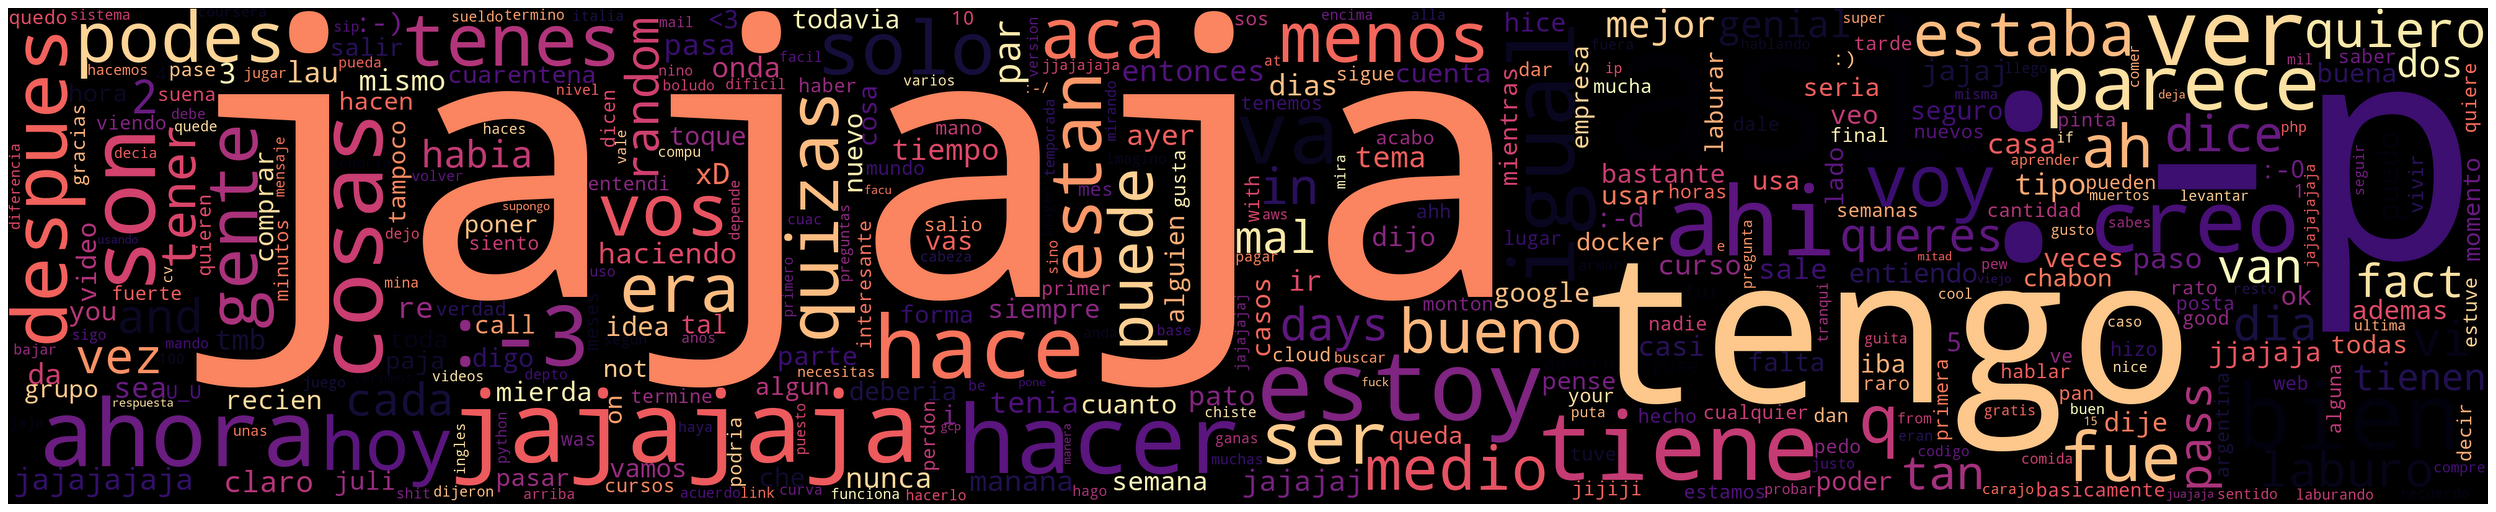

In [38]:
# Show a word cloud for the most used words

word_freq= defaultdict(int)
for word in one_grams:
    word_freq[word]+=1

wc = WordCloud(width = 4000, height = 800,
               min_font_size=10,max_words=400,
              mode='RGBA',colormap='magma',
              min_word_length=2).generate_from_frequencies(word_freq)
#wc.to_file('words.png')
plt.figure(figsize=(40, 30), dpi= 80, edgecolor='k')
plt.imshow(wc, interpolation="lanczos")
plt.axis("off")
plt.show()

### It would seem the most common word is `jajaja`, the laughing onomatopoeia for Spanish, followed by the tongue emoji in it's text form `:-p`

In [39]:
# filter the one_grams that appear in emoji
emojis=[word for word in one_grams if word in emoj]
# create an emoji counter
emoji_freq= defaultdict(int)
for em in emojis:
    emoji_freq[em]+=1
emoji_sorted_key,emoji_sorted_value= zip(* sorted(
        emoji_freq.items(), key=lambda item: item[1]))

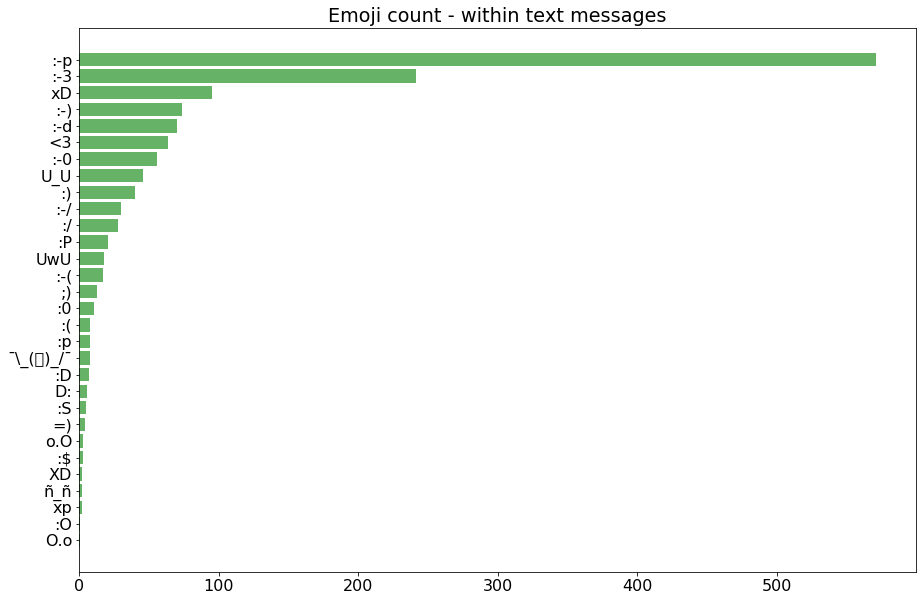

In [40]:
plt.figure(figsize=(15, 10))
plt.rcParams['font.size']=16
plt.title('Emoji count - within text messages')
plt.barh(emoji_sorted_key, emoji_sorted_value, color='g',alpha=0.6);

### It would seem like we've got a pretty diverse emoji vocabulary... but what about the most repeated phrases?

In [41]:
# I'm leaving out the bot and counting in the stopwords for this part
one_grams_withStop=[]
weird_one_grams_withStop=[]
non_string_messages_withStop=[]
for msg in text_df.loc[text_df['from'] != 'bot']['text']:
    if isinstance(msg,str):
        msg_1gram,weird_gram = process_msg(msg,False,True)
        one_grams_withStop.extend(msg_1gram)
        weird_one_grams_withStop.extend(weird_gram)
    else:
        non_string_messages_withStop.append(msg)

#### Taking a close look at the 4-word ngram, we can see the most usual 4 word sentence is explanatory ("the issue is that...")

In [42]:
msg4Grams_withStop = ngrams(one_grams_withStop, 4)
fourGramFreq_withStop = collections.Counter(msg4Grams_withStop)
top4gram= fourGramFreq_withStop.most_common(6)
top4gram

[(('el', 'tema', 'es', 'que'), 21),
 (('no', 'se', 'si', 'es'), 12),
 (('un', 'par', 'de', 'dias'), 11),
 (('un', 'par', 'de', 'cosas'), 9),
 (('de', 'las', 'cosas', 'que'), 8),
 (('la', 'idea', 'es', 'que'), 8)]

#### If we go to the 3-word ngram, by far the most usual sentence translates as "a couple of"

In [43]:
msg3Grams_withStop = ngrams(one_grams_withStop, 3)
threeGramFreq_withStop = collections.Counter(msg3Grams_withStop)
top3gram= threeGramFreq_withStop.most_common(6)
top3gram

[(('un', 'par', 'de'), 105),
 (('o', 'algo', 'asi'), 47),
 (('de', 'lo', 'que'), 41),
 (('no', 'se', 'si'), 41),
 (('el', 'tema', 'es'), 37),
 (('tema', 'es', 'que'), 33)]

## lets take a look through time

In [44]:
# declare df
user_msg_df= text_df.loc[text_df['from'] != 'bot']
user_msg_df= user_msg_df.loc[text_df['from'] != 'Book Download Bot']
# convert date to utc
user_msg_df['date']=pd.to_datetime(user_msg_df['date'], utc=True)
# normalizing text as text
user_msg_df['text']=user_msg_df['text'].astype(str)

#### Plotting the amount of messages per user through the day

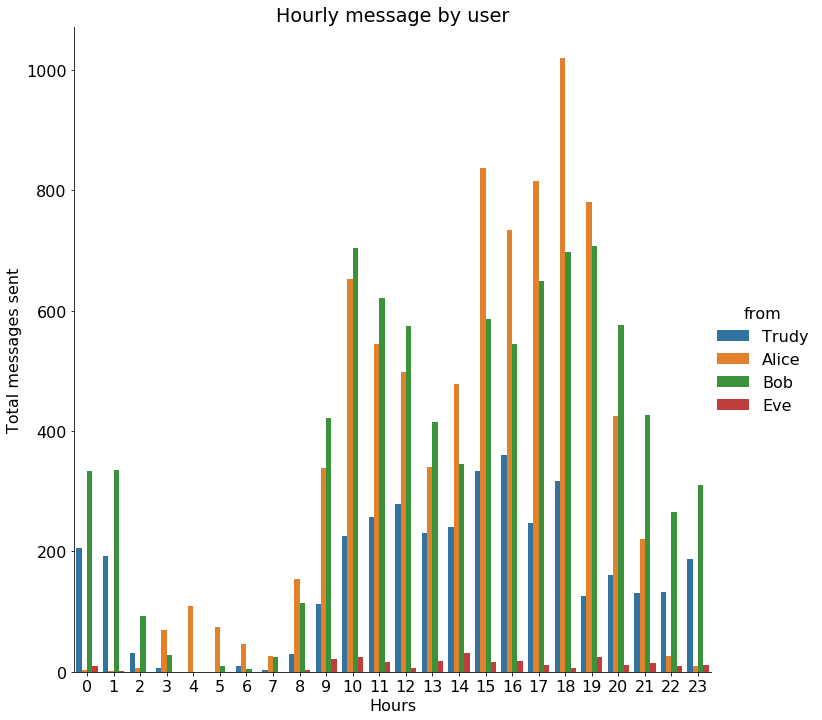

In [45]:
# Thanks to Karina Bartolome and Fabricio Previgliano for this df transition
user_msg_df['hour']=user_msg_df['date'].dt.to_period("H")
user_msg_df['hour']=user_msg_df['hour'].dt.hour
user_msg_df.groupby(['from', 'hour'],as_index=False).agg('count')

g = sns.catplot(x='hour', hue="from",
                data=user_msg_df[['from','text','hour']], kind="count",
                height=10,orient='h')
g.set(xlabel="Hours", ylabel = "Total messages sent")
plt.title('Hourly message by user');

###### We see a couple of trends here:
* Alice sends more messages in the afternoon
* Bob sends more messages around 10 am and 7 pm
* Trudy is pretty constant with the amount of messages he sends through the day
* Finally, it is clear that Eve doesn't talk much

 #### The monthly activity has increased significantly since Feb-2020

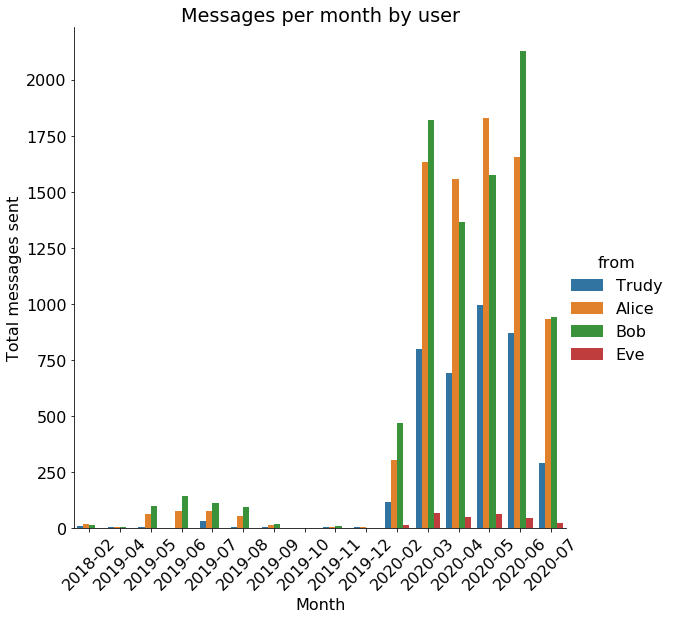

In [46]:
user_msg_df['month']=user_msg_df['date'].dt.to_period("M")
user_msg_df.groupby(['from', 'month'],as_index=False).agg('count')

g = sns.catplot(x="month", hue="from",
                data=user_msg_df, kind="count",
                height=8,orient='h')
g.set_xticklabels(rotation=45)
#g.set_xticklabels(get_xticklabels(), rotation=40, ha="right")
g.set(xlabel="Month", ylabel = "Total messages sent")
plt.title('Messages per month by user');

##### The amount of messages has ski-rocketed since Feb-2020... might have something to do with the lockdown.

##### Remember Bob's passion for responding to messages with a single 😂 emoji? Let's track it's use over time... see what happens

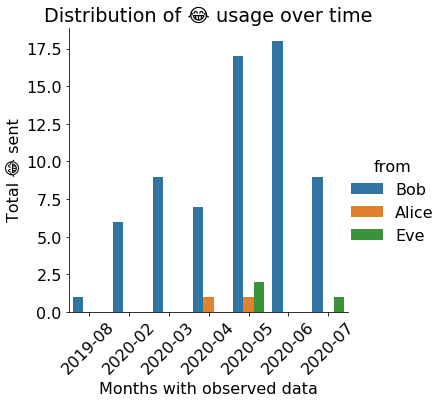

In [47]:
bobsEmoji_df=user_msg_df[user_msg_df['text'].str.contains("😂")]

g = sns.catplot(x="month", hue="from",
                data=bobsEmoji_df, kind="count",
                height=5,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Total 😂 sent")
plt.title('Distribution of 😂 usage over time');


#### What about the most common word: `jajaja` ?

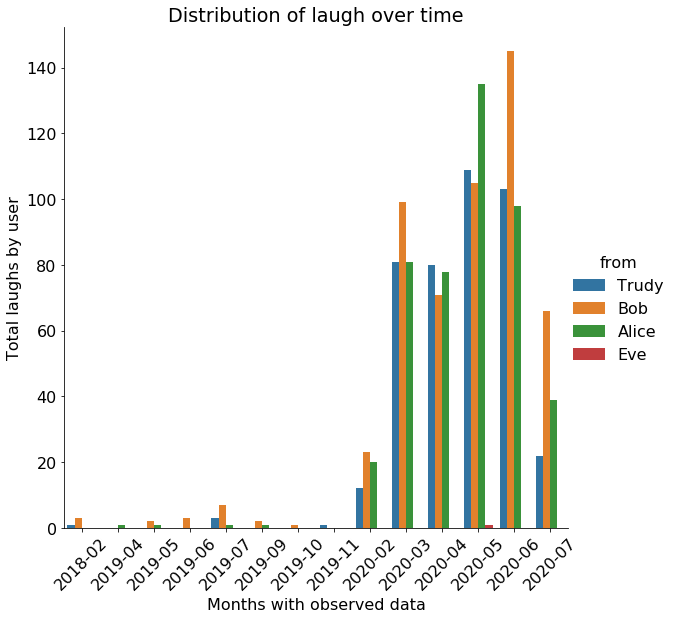

In [48]:
catFace_df= user_msg_df[user_msg_df['text'].str.contains("jajaja")]

g = sns.catplot(x="month", hue="from",
                data=catFace_df, kind="count",
                height=8,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Total laughs by user")
plt.title('Distribution of laugh over time');


#### This was to be expected, since under lockdown we try to cheer each other up... let's track the use of the word. Apparently, Bob was a bit worried about this subject when the pandemic hit the Western Hemisphere back in March 2020

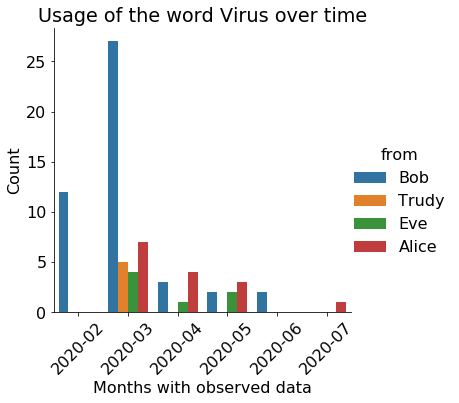

In [49]:
catFace_df= user_msg_df[user_msg_df['text'].str.contains("virus")]

g = sns.catplot(x="month", hue="from",
                data=catFace_df, kind="count",
                height=5,orient='h')
g.set_xticklabels(rotation=45)
g.set(xlabel="Months with observed data", ylabel = "Count")
plt.title('Usage of the word Virus over time');

# For the next session I'll try to fix my spelling mistakes and probably study the URLs that are embedded in the text messages

In [50]:
#TODO:
 # Explore the `text` based messages (22k messages should be the most juicy data)
# analyze individual's activity from text-based messages
# calculate distribution for text messages by individual
# calculate distribution for urls shared
# calculate correlation between messages sent by group members
# perhaps try to train an AI using those 22k messages as the corpus